# **01번. MNIST 데이터셋으로 분류기를 만들어 테스트 세트에서 97% 정확도를 달성해보세요.**

In [2]:
from sklearn import datasets
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### **MNIST 데이터셋 불러오기**

In [3]:
# iris = datasets.load_iris()
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [4]:
type(mnist)

sklearn.utils._bunch.Bunch

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

### **모델링**

In [7]:
model = KNeighborsClassifier()
model.fit(X_train, y_train)
baseline_accuracy = model.score(X_test, y_test)
baseline_accuracy

# 정확도만 판단하면 되므로 다른 f1, 재현율 등 고려 X

0.9688

> KNN의 경우, 최적의 하이퍼파라미터 탐색이 필요

* 이때, sklean.model_selection 모듈에 있는 GridSearchCV라는 함수를 불러옵니다
* 이를 통해 찾고자 하는 것은 이웃의 수인 'k'
* GridSearch : 모든 조합들을 다 test 해보겠다는 의미

In [8]:
from sklearn.model_selection import GridSearchCV

# 최적화할 하이퍼파라미터 범위 설정

param_grid = {
    'n_neighbors': range(3, 6),
    'weights': ['uniform', 'distance']
}

In [9]:
# 최적 하이퍼파라미터 탐색
grid_search = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'accuracy',
                           refit = True, # 최적 하이퍼파라미터로 재학습
                           n_jobs = -1)


grid_search.fit(X_train[:10000], y_train[:10000])

best_model = grid_search.best_estimator_  # 탐색된 최적 파라미터로 학습된 모델
print(f'best_parameter: {grid_search.best_params_}') # 탐색된 최적 파라미터
print(f'best_score: {grid_search.best_score_}') # 탐색된 최적 파라미터로 학습된 결과

best_parameter: {'n_neighbors': 4, 'weights': 'distance'}
best_score: 0.9441999999999998


In [10]:
print(best_model)

KNeighborsClassifier(n_neighbors=4, weights='distance')


In [11]:
grid_search.best_estimator_.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [12]:
tuned_accuracy = grid_search.score(X_test, y_test)
tuned_accuracy

0.9714

# **02번. MNIST 이미지를  (왼, 오른, 위, 아래 ) 어느 방향으로든 한 픽셀 이동시킬 수 있는 함수를 만들어보세요**

### **이동시키는 함수 작성**

> SciPy 라이브러리의 ndimage 모듈 내에서 이미지 및 다차원 배열을 다루는 기능 중 하나인 shift 함수

In [13]:
from scipy.ndimage.interpolation import shift

<ipython-input-13-c50379b1544a>:1: DeprecationWarning: Please import `shift` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import shift


In [14]:
import numpy as np

# 3x3 배열 생성
arr = np.array([[1, 2, 3],
                [4, 5, 6],
                [7, 8, 9]])

# 배열을 오른쪽으로 1칸, 아래로 1칸 이동
shifted_arr = shift(arr, shift=[1, 1], mode='constant', cval=0)

print(shifted_arr)

# shift=[1,1] → 아래로 1칸, 오른쪽으로 1칸 이동
# mode='constant' → 빈 공간을 cval=0 값으로 채움

[[0 0 0]
 [0 1 2]
 [0 4 5]]


MNIST 데이터셋의 X 데이터는 각 숫자 이미지를 1차원 벡터 (784,) 형태로 저장하고 있기 때문에 우리가 일반적으로 보는 (28x28) 픽셀의 이미지 형태로 변환하려면 reshape(28, 28)을 사용

In [15]:
def shift_image(image, dx, dy):
    image = image.reshape((28, 28))
    move_image = shift(image, [dy, dx], mode="constant", cval=0)
    return move_image.reshape([-1])

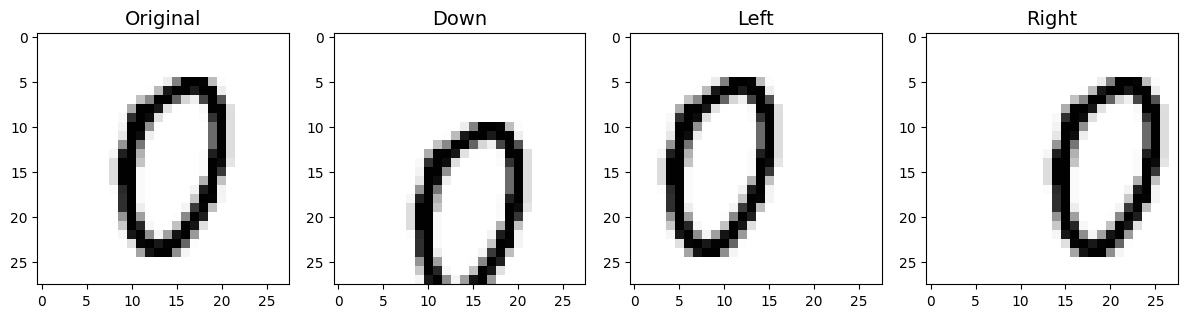

In [16]:
import matplotlib.pyplot as plt

image = X_train[1000]
image_down = shift_image(image, 0, 5)
image_left = shift_image(image, -5, 0)
image_right = shift_image(image, 5, 0)


import matplotlib.pyplot as plt

# 1x4 그리드로 이미지 배치
fig, axes = plt.subplots(1, 4, figsize=(12, 3))
titles = ["Original", "Down", "Left", "Right"]
images = [image, image_down, image_left, image_right]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(img.reshape(28, 28), cmap="Greys", interpolation="nearest")
    ax.set_title(title, fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
X_train_augmentation = [image for image in X_train]
y_train_augmentation = [label for label in y_train]

# 각 이미지에 대해 네 방향으로 이동한 총 4개의 새로운 데이터가 추가됨
# (원본 1개 + 이동된 4개 → 총 5배 데이터 증가!)
for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)):
    for image, label in zip(X_train, y_train):
        X_train_augmentation.append(shift_image(image, dx, dy))
        y_train_augmentation.append(label)

X_train_augmentation = np.array(X_train_augmentation)
y_train_augmentation = np.array(y_train_augmentation)

In [ ]:
# shuffle_idx = np.random.permutation(len(X_train_augmentation))
# X_train_augmentation = X_train_augmentation[shuffle_idx]
# y_train_augmentation = y_train_augmentation[shuffle_idx]

In [18]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

In [20]:
knn_clf.fit(X_train_augmentation, y_train_augmentation)

KNeighborsClassifier(n_neighbors=4, weights='distance')

In [21]:
augmented_accuracy = knn_clf.score(X_test, y_test)

In [22]:
augmented_accuracy

0.9763

# 번외

> keras에 ImageDataGenerator라는 라이브러리를 이용하여 쉽게 데이터 증강을 할 수 있다.

> `ImageDataGenerator()` 함수 안에 여러 하이퍼 파라미터를 설정하여 데이터 증량을 정의하면 된다.

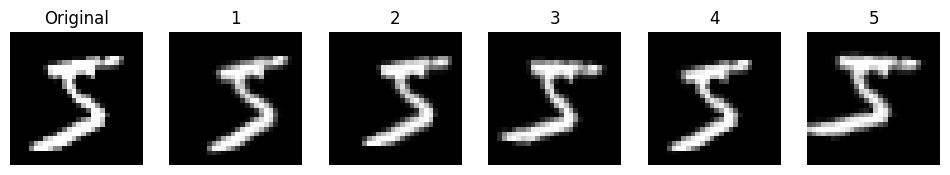

In [25]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 데이터 정규화 (0~255 → 0~1) 및 4D 변환
X_train_keras = X_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
X_test_keras = X_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

# ImageDataGenerator 파라미터 설정
datagen = ImageDataGenerator(
    rotation_range=15,      # 회전 (최대 ±15도)
    width_shift_range=0.1,  # 좌우 이동 (10%)
    height_shift_range=0.1, # 상하 이동 (10%)
    zoom_range=0.1          # 확대/축소 (10%)
)

# 데이터 증강 (첫 번째 이미지 -> 5개 버전으로 증강)
img_batch = np.expand_dims(X_train_keras[0], axis=0)  # 첫 번째 이미지 선택
augmented_images = [img_batch[0]]

for batch in datagen.flow(img_batch, batch_size=1):
    augmented_images.append(batch[0])  # 변형된 이미지 추가
    if len(augmented_images) >= 6:  # 원본 포함 6개 이미지 저장
        break

fig, axes = plt.subplots(1, 6, figsize=(12, 2))
titles = ['Original', '1', '2', '3', '4', '5']

for ax, img, title in zip(axes, augmented_images, titles):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(title)
    ax.axis("off")

plt.show()
